# Dimensionality Reduction for Customer Segmentation

**Project context**

This project uses the Online Retail II dataset, which records two years of transactions from a UK-based online giftware retailer.
The dataset includes invoices, product descriptions, quantities, prices, timestamps, and customer identifiers.

**Business objective**

The goal is to build meaningful customer segments that help the business:
- understand behavioural patterns,
- identify high-value vs low-engagement customers,
- spot dormant or at-risk customers,
- support targeted marketing and product strategy.

---

This notebook focuses on reducing the high-dimensional feature space created in the previous step into lower-dimensional representations (2D and 3D). This is a critical step to visualize the data structure, identify potential clusters, and prepare the data for density-based clustering algorithms.

**Objectives**
- Apply PCA to identify the principal components and reduce dimensionality while retaining variance.
- Use UMAP and t-SNE to capture non-linear relationships and local structures.
- Compare the effectiveness of different reduction techniques.
- Export the reduced embeddings for the clustering phase.

**Pipeline overview**
1. Load processed customer data and the fitted scaler.
2. Perform PCA analysis (variance explained, optimal components).
3. Perform UMAP analysis with parameter tuning.
4. Perform t-SNE analysis with perplexity tuning.
5. Compare methods and save results.

## 1. Setup and Imports

In [18]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Plot settings
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Paths
DATA_DIR = Path('../data/processed')
MODELS_DIR = Path('../models')
IMAGES_DIR = Path('../images')

def save_fig(name):
    plt.savefig(IMAGES_DIR / f"{name}.png", dpi=300, bbox_inches='tight')

## 2. Load processed customer dataset

In [19]:
# Load data
df = pd.read_csv(DATA_DIR / 'customers_final.csv')

# Separate ID and features
customer_ids = df['CustomerID']
X = df.drop(columns=['CustomerID'])

print(f"Data shape: {df.shape}")
print(f"Features shape: {X.shape}")
X.head()

Data shape: (5878, 48)
Features shape: (5878, 47)


,Frequency,Monetary,Recency,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,...,Country_Switzerland,Country_Thailand,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,Country_West Indies,AvgBasketValue,BasketValueVariance,DistinctProducts
0,0.438998,5.166378,0.595584,-0.048862,-0.0433,-0.018449,-0.069183,-0.018449,-0.029178,-0.04708,...,-0.061293,-0.013044,-0.03916,-0.026095,0.314152,-0.031966,-0.013044,5.005717,4.882138,-0.472112
1,0.131502,0.136127,-0.952279,-0.048862,-0.0433,-0.018449,-0.069183,-0.018449,-0.029178,-0.04708,...,-0.061293,-0.013044,-0.03916,-0.026095,-3.183171,-0.031966,-0.013044,0.189436,-0.014699,0.377858
2,-0.099120,-0.064857,-0.603532,-0.048862,-0.0433,-0.018449,-0.069183,-0.018449,-0.029178,-0.04708,...,-0.061293,-0.013044,-0.03916,-0.026095,-3.183171,-0.031966,-0.013044,0.015401,-0.014964,-0.489283
3,-0.175994,0.101996,-0.871064,-0.048862,-0.0433,-0.018449,-0.069183,-0.018449,-0.029178,-0.04708,...,-0.061293,-0.013044,-0.03916,-0.026095,-3.183171,-0.031966,-0.013044,0.594632,-0.012044,0.480885
4,-0.406616,-0.181549,0.519146,-0.048862,-0.0433,-0.018449,-0.069183,-0.018449,-0.029178,-0.04708,...,-0.061293,-0.013044,-0.03916,-0.026095,-3.183171,-0.031966,-0.013044,-0.041823,-0.015639,-0.557968


## 3. PCA Analysis

PCA is a linear dimensionality reduction technique. We use it to understand the global structure of the data and determine how many components are needed to explain the majority of the variance.

### 3.1 Fit PCA and Explained Variance

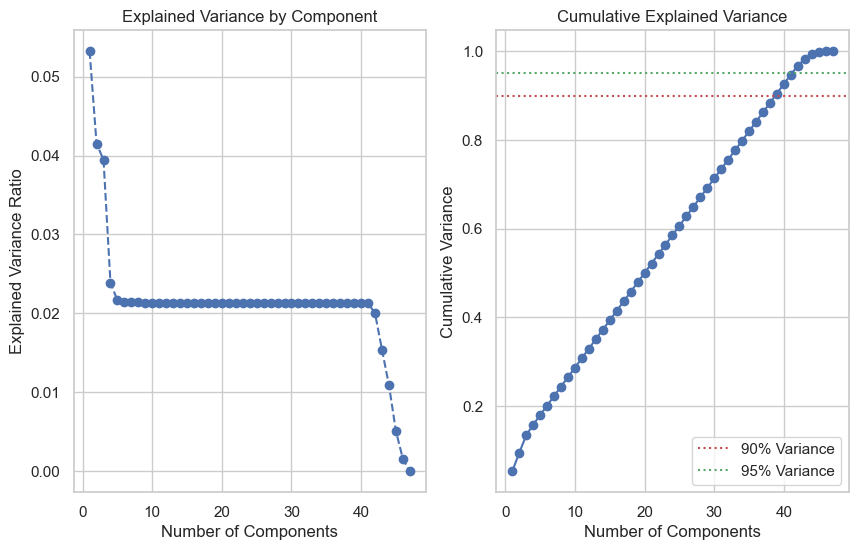

In [20]:
pca = PCA(random_state=42)
pca.fit(X)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.90, color='r', linestyle=':', label='90% Variance')
plt.axhline(y=0.95, color='g', linestyle=':', label='95% Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.legend()

save_fig('pca_variance')
plt.show()

Including all country one-hot encoded variables (≈ 40 binary columns) heavily skews the PCA results.  
These columns are sparse, mutually exclusive, and high-dimensional, causing PCA to allocate most of its explained variance to geographic dummy splits rather than actual behavioural patterns.

To obtain a meaningful and interpretable decomposition, PCA is recomputed using only core behavioural features:

- `Frequency`
- `Monetary`
- `Recency`
- `AvgBasketValue`
- `BasketValueVariance`
- `DistinctProducts`

This shifts the focus toward true purchasing behaviour and yields a variance structure better suited for downstream clustering.

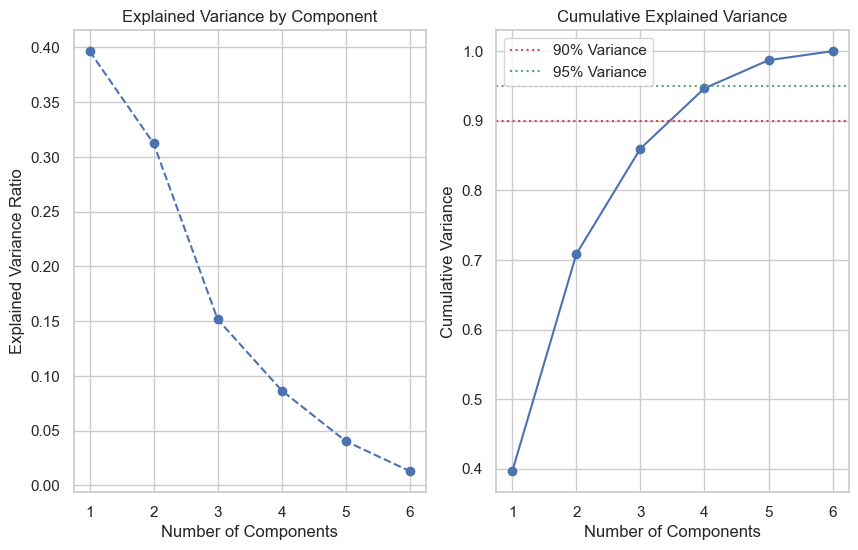

In [21]:
behavior_cols = [
    'Frequency', 
    'Monetary', 
    'Recency', 
    'AvgBasketValue', 
    'BasketValueVariance', 
    'DistinctProducts'
]
X_pca_input = X[behavior_cols]

pca = PCA(random_state=42)
pca.fit(X_pca_input)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.90, color='r', linestyle=':', label='90% Variance')
plt.axhline(y=0.95, color='g', linestyle=':', label='95% Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.legend()

save_fig('pca_variance_witout_countrys')
plt.show()

In [22]:
print(f"Explained variance: ({np.round(explained_variance, 3)}")
print(f"Cumulative variance: {np.round(cumulative_variance, 3)}\n")

n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

print(f"Components for 90% variance: {n_components_90}")
print(f"Components for 95% variance: {n_components_95}")
print(f"Components for 99% variance: {n_components_99}")

Explained variance: ([0.396 0.312 0.151 0.087 0.04  0.013]
Cumulative variance: [0.396 0.709 0.86  0.947 0.987 1.   ]

Components for 90% variance: 4
Components for 95% variance: 5
Components for 99% variance: 6


The PCA results show that the behavioural features compress extremely well:

- **2 components already explain ~70% of the total variance**, meaning most customer behaviour can be summarized along just two axes.
- **3 components account for ~86%**, capturing nearly all major behavioural differences.
- **4 components account for ~95%**, which is typically considered more than sufficient for clustering or downstream modelling.
- **5-6 components reach ~99%**, adding only marginal gains.

This confirms that the dataset has a strong low-dimensional structure. A small number of latent behavioural factors drive most customer variability, which makes PCA an effective starting point for segmentation and a good baseline to compare against non-linear reductions such as UMAP and t-SNE.

---

### 3.2 PCA 2D and 3D Projections

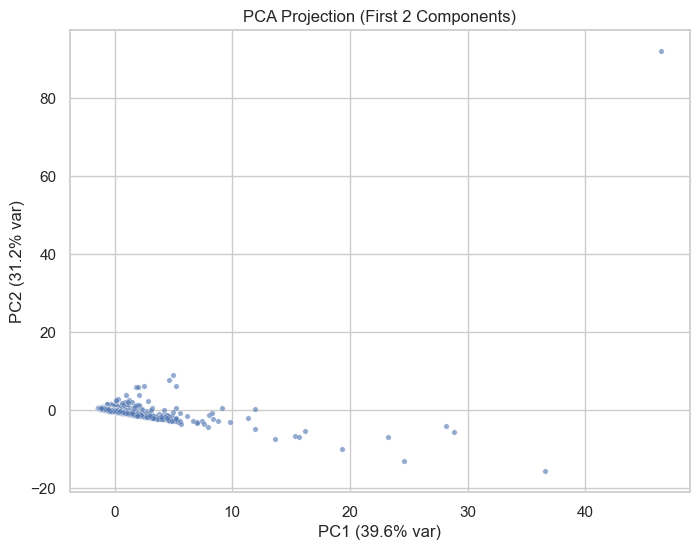

<Figure size 800x600 with 0 Axes>

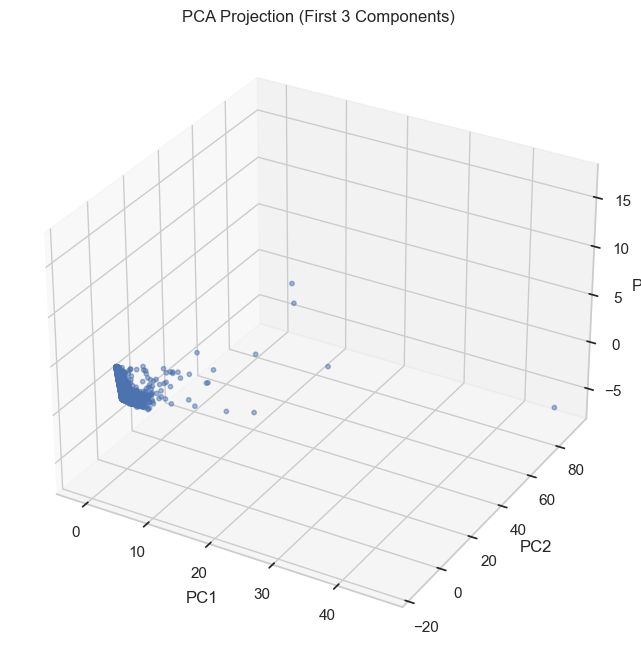

In [26]:
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_pca_input)

# 2D Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_3d[:, 0], y=X_pca_3d[:, 1], alpha=0.6, s=15)
plt.title('PCA Projection (First 2 Components)')
plt.xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%} var)')
plt.ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%} var)')
save_fig('pca_2d')
plt.show()

# 3D Plot
plt.figure(figsize=(8, 6))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], alpha=0.5, s=10)
ax.set_title('PCA Projection (First 3 Components)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
save_fig('pca_3d')
plt.show()

The PCA plots show a very dense cluster of customers with only a few extreme outliers. This is typical for retail data, where most customers behave similarly. PCA, being linear, compresses this shared variance and does not reveal deeper structure. This does not mean clustering will fail, only that PCA is limited for uncovering subtle behavioural groups.

Next, applying **UMAP** and **t-SNE** will provide non-linear embeddings that separate patterns more clearly and give a better foundation for clustering.

---

## 4. UMAP Analysis

Uniform Manifold Approximation and Projection (UMAP) is a non-linear technique that preserves both local and global structure better than PCA for complex datasets.

### 4.1 Parameter Exploration

c:\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Python312\Lib\site-packages\umap\umap_.py:1952: UserWar

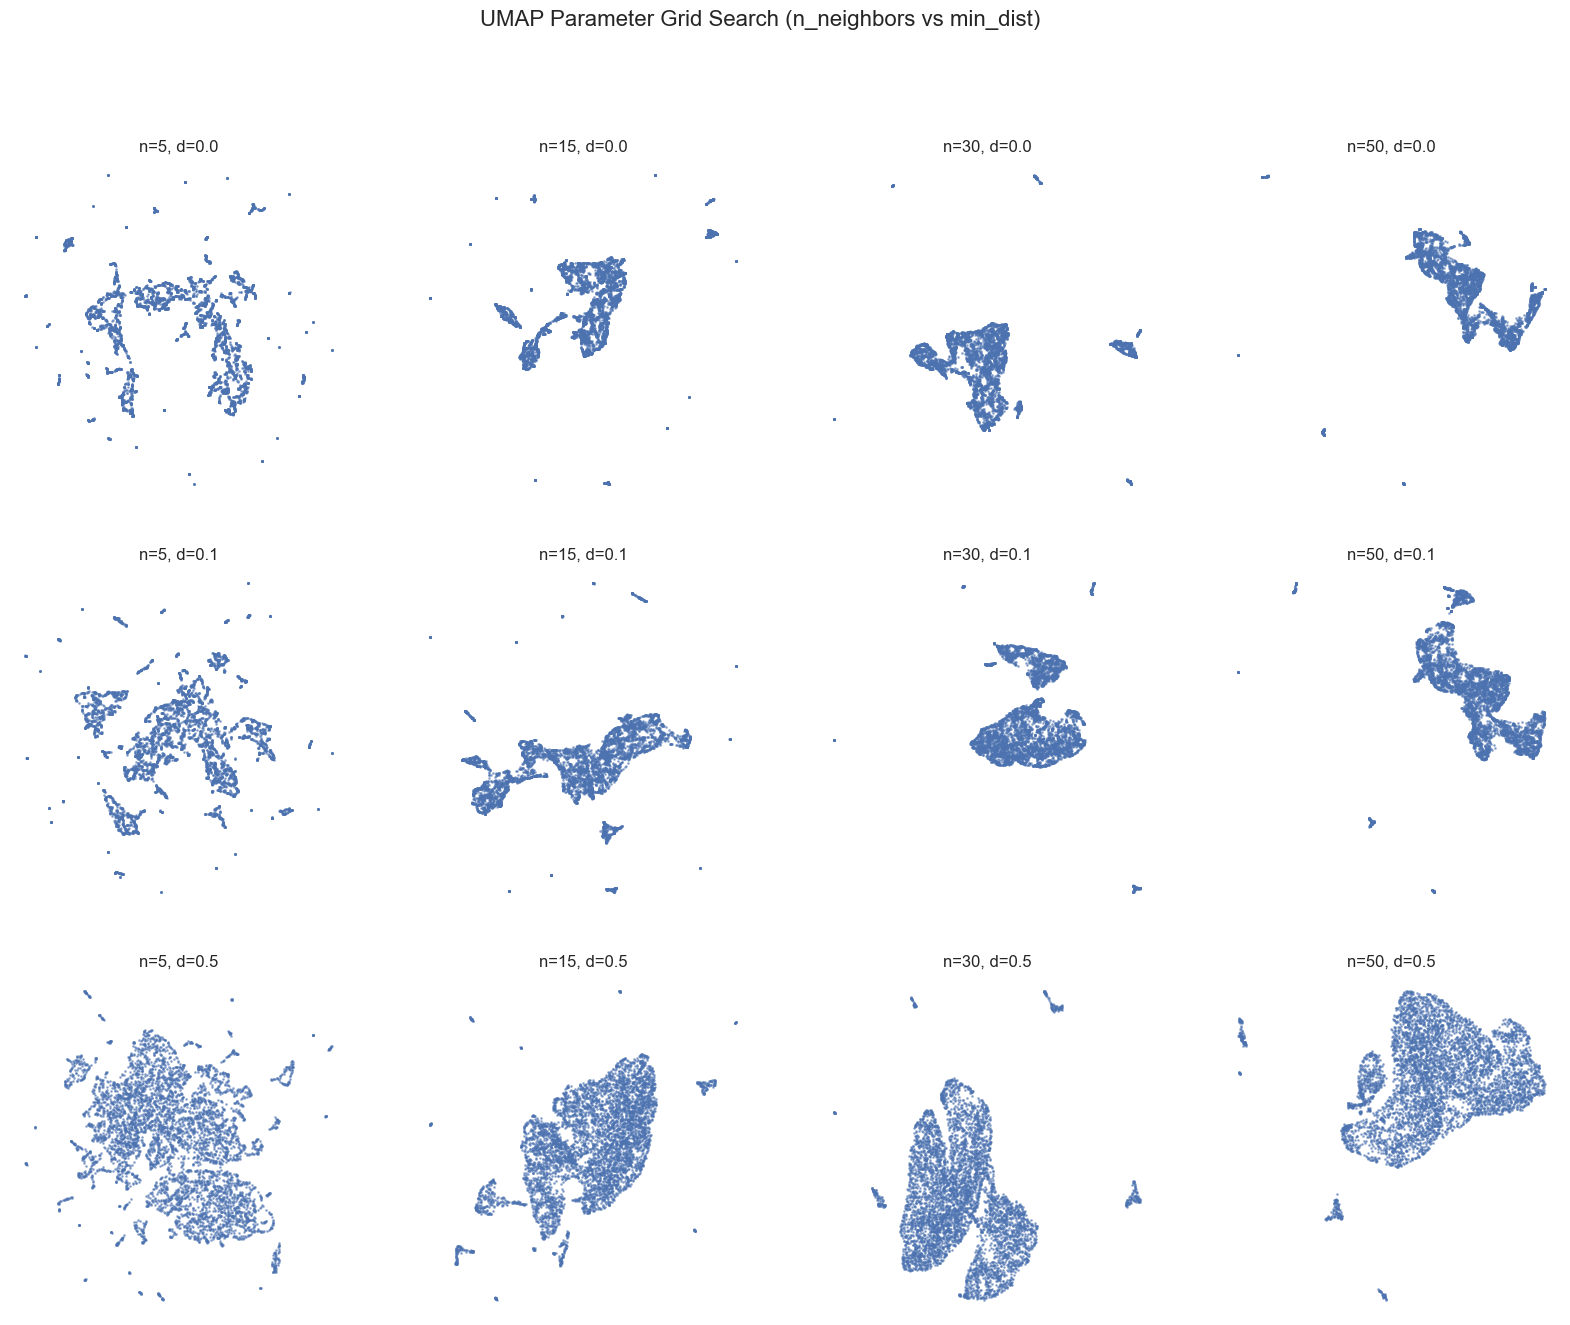

In [27]:
neighbors_list = [5, 15, 30, 50]
min_dist_list = [0.0, 0.1, 0.5]

fig, axes = plt.subplots(len(min_dist_list), len(neighbors_list), figsize=(20, 15))
fig.suptitle('UMAP Parameter Grid Search (n_neighbors vs min_dist)', fontsize=16)

for i, min_dist in enumerate(min_dist_list):
    for j, n_neighbors in enumerate(neighbors_list):
        umap_model = UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=2,
            random_state=42,
            n_jobs=-1
        )
        embedding = umap_model.fit_transform(X)
        
        ax = axes[i, j]
        ax.scatter(embedding[:, 0], embedding[:, 1], s=1, alpha=0.5)
        ax.set_title(f'n={n_neighbors}, d={min_dist}')
        ax.axis('off')

save_fig('umap_grid')
plt.show()

The grid shows how UMAP behaves under different parameter settings:

- **Low n_neighbors (5)** → Highly fragmented, noisy embeddings. The algorithm overfits local patterns, producing many small disconnected islands.
- **Medium n_neighbors (15-30)** → Most stable and meaningful structures. Clusters become compact, coherent, and consistent across min_dist values.
- **High n_neighbors (50)** → Oversmoothed shapes. Global structure dominates and fine details disappear.

For **min_dist**:
- **0.0** → Very tight, compact clusters.
- **0.1** → Good balance between density and readability.
- **0.5** → More spread-out embeddings with clearer substructure.

**Best region:**  
Settings around **n_neighbors = 15-30** and **min_dist = 0.1-0.5** yield the cleanest, most cluster-friendly embeddings.

---

### 4.2 Final UMAP Projection

Based on the grid search, we select a balanced configuration (n_neighbors=30, min_dist=0.1) to capture structure.

c:\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


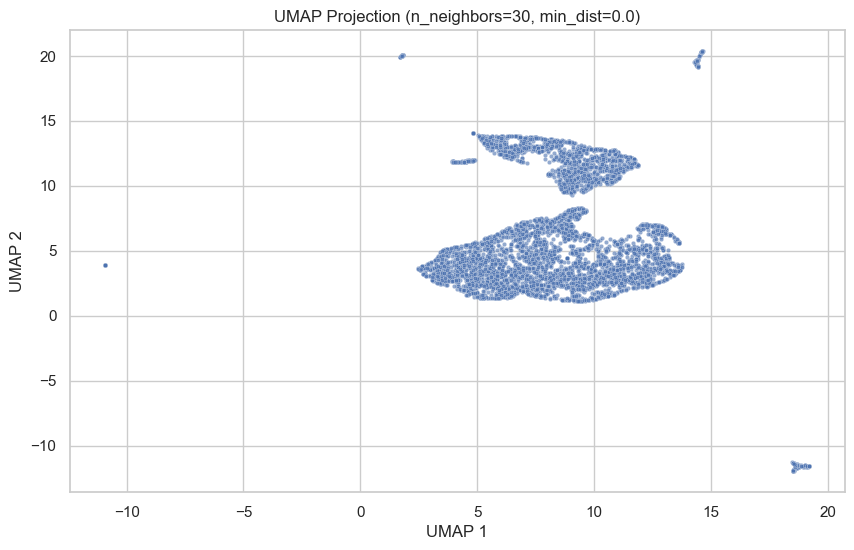

In [30]:
# Using selected parameters
umap_final = UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    n_jobs=-1
)
X_umap = umap_final.fit_transform(X)

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], alpha=0.6, s=10)
plt.title('UMAP Projection (n_neighbors=30, min_dist=0.0)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
save_fig('umap_2d')
plt.show()

## 5. t-SNE Analysis

t-Distributed Stochastic Neighbor Embedding (t-SNE) is another popular non-linear technique, particularly good at preserving local structure.

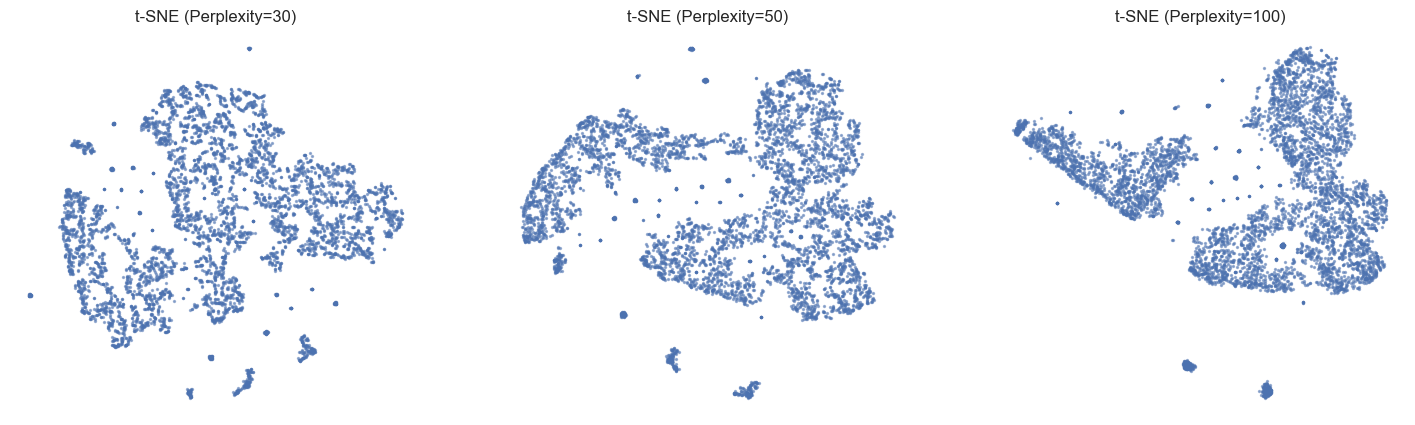

In [ ]:
perplexities = [30, 50, 100]

plt.figure(figsize=(18, 5))

for i, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, n_jobs=-1)
    X_tsne = tsne.fit_transform(X)
    
    plt.subplot(1, 3, i+1)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=2, alpha=0.5)
    plt.title(f't-SNE (Perplexity={perp})')
    plt.axis('off')

save_fig('tsne_2d')
plt.show()

t-SNE provides another non-linear view of the customer space, focusing on preserving local neighborhoods.  
Across the tested perplexities (30, 50, 100), the projections remain broadly consistent: customers form several loose groups with smooth transitions rather than sharp, isolated clusters. Higher perplexities (e.g., 100) produce more elongated, global structures, while lower ones (30-50) emphasize fine-grained local patterns.

Overall, t-SNE confirms the same insight as UMAP:  
the customer space does not exhibit strongly separated clusters but rather continuous behavioural gradients.  
This suggests that clustering may still be meaningful, but algorithms should be chosen with these characteristics in mind (e.g., density-based or soft clustering instead of expecting clear, spherical partitions).

---

## 6. Method Comparison & Insights

**PCA**:
- Preserves global structure and variance.
- Shows that a significant portion of variance is captured by the first few components, but the data does not separate into clear, distinct clusters in the linear 2D space.
- Useful for initial noise reduction before clustering.

**UMAP**:
- Reveals more detailed local structures and potential micro-clusters.
- The grid search shows that lower `min_dist` values tend to create tighter clusters.
- Likely the best candidate for density-based clustering (e.g., DBSCAN, HDBSCAN) due to its ability to separate dense regions.

**t-SNE**:
- Similar to UMAP but often computationally more expensive and harder to tune globally.
- Shows good separation of local neighborhoods but global distances are less meaningful.

**Conclusion**:
We will proceed with clustering using the original scaled features or the PCA-reduced features for algorithms like K-Means. For density-based approaches or visualization of the final clusters, the UMAP embeddings will be highly valuable.

---

## 7. Export Results

I save the 2D coordinates from each method to facilitate easy plotting in the clustering notebook.

In [35]:
df_pca = pd.DataFrame(X_pca_3d[:, :2], columns=['PCA1', 'PCA2'])
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_tsne = pd.DataFrame(X_tsne_final, columns=['TSNE1', 'TSNE2'])

df_pca['CustomerID'] = customer_ids.values
df_umap['CustomerID'] = customer_ids.values
df_tsne['CustomerID'] = customer_ids.values

df_pca.to_csv(DATA_DIR / 'pca_2d.csv', index=False)
df_umap.to_csv(DATA_DIR / 'umap_2d.csv', index=False)
df_tsne.to_csv(DATA_DIR / 'tsne_2d.csv', index=False)

Although PCA 4D and 6D capture most of the variance, these linear embeddings do 
not preserve the non-linear structures that matter for clustering. For this 
reason, the clustering notebook will rely on a **single UMAP 10-dimensional 
embedding**, which captures both local density patterns and global structure.

All clustering algorithms (K-Means, GMM, DBSCAN, HDBSCAN) will be evaluated in 
the same space (UMAP-10D), ensuring a fair comparison. 

The 2D PCA/UMAP/t-SNE embeddings will only be used later for visualization of the resulting clusters.

In [37]:
umap_10d = UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=10,
    random_state=42,
    n_jobs=-1
)

X_umap_10d = umap_10d.fit_transform(X)
print("UMAP 10D embedding shape: ", X_umap_10d.shape)

c:\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 10D embedding shape:  (5878, 10)


In [38]:
df_umap_10d = pd.DataFrame(X_umap_10d, columns=[f'UMAP{i+1}' for i in range(X_umap_10d.shape[1])])
df_umap_10d['CustomerID'] = customer_ids.values

df_umap_10d.to_csv(DATA_DIR / 'umap_10d.csv', index=False)